In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

1. Сгенерировать данные
2. Посчитать определенные значения, которые бизнес хочет вычислить

50 измерений, 5 регионов

id, sales (условные единицы), sales_region

1,80,Country1

105,150,Country2

2,50,Country3

In [2]:
def load_countries_name(n):
    url = 'https://randomuser.me/api/'
    params = {'results': n} 
    response = requests.get(url, params)
    data = response.json()['results']
    countries = [user['location']['country'] for user in data]
    return countries
    
def generate_product_id(n):
    return np.random.randint(1, 20, n)

def generate_region_sales(n):
    return np.round(np.random.uniform(low=10.0, high=350.0, size=n), 2)

def generate_regions(n, city_names = []):
    return np.random.choice(city_names, n)
    

ROWS_CNT = 50
REGIONS_CNT = 5
city_names = load_countries_name(REGIONS_CNT)
data = np.column_stack((generate_product_id(ROWS_CNT), generate_region_sales(ROWS_CNT), generate_regions(ROWS_CNT, city_names)))

np.savetxt('data.txt', data, delimiter=',', fmt='%s')

In [3]:
data = np.loadtxt('data.txt', delimiter=',', dtype='str')

In [4]:
unique_ids = np.unique(data[:, 0])
unique_regions = np.unique(data[:, 2])
sales = data[:, 1].astype(float)

In [5]:
data[:, 1] = data[:, 1].astype(float) # почему-то он не сохраняет колонку числовой

### Какова общая сумма продаж для всех продуктов?

In [6]:
print(f'Общая сумма продаж: {sales.sum()}')

Общая сумма продаж: 8562.340000000002


### Сколько уникальных регионов продаж существует? 

In [7]:
print(f'Уникальных регионов: {unique_regions.size}')

Уникальных регионов: 5


### Какова средняя сумма продаж на продукт?

In [8]:
sales_sum_by_id = []
for id_ in unique_ids:
    filtered_data = data[data[:, 0] == str(id_)]
    column_sum = np.sum(filtered_data[:, 1].astype(float))
    sales_sum_by_id.append([id_, column_sum])

sales_sum_by_id = np.array(sales_sum_by_id)

In [9]:
print(f'Средняя сумма продаж на продукт: {np.mean(sales_sum_by_id.astype(float))}')

Средняя сумма продаж на продукт: 230.32473684210527


### Какой продукт имеет наибольшую сумму продаж?

In [10]:
max_sales = np.max(sales_sum_by_id[:, 1].astype(float))
max_sales_id = sales_sum_by_id[sales_sum_by_id[:, 1] == str(max_sales)][0][0]

In [11]:
print(f'Продукт с id {max_sales_id} имеет наибольшую сумму продаж, равную {max_sales}')

Продукт с id 16 имеет наибольшую сумму продаж, равную 982.24


### Рассчитайте сумму продаж для каждого региона продаж. (постройте круговую гистограмму)

In [12]:
sales_sum_by_region = []
for region in unique_regions:
    filtered_data = data[data[:, 2] == str(region)]
    column_sum = np.sum(filtered_data[:, 1].astype(float))
    sales_sum_by_region.append([region, column_sum])

sales_sum_by_region = np.array(sales_sum_by_region)

In [13]:
sales_sum_by_region

array([['Finland', '3009.67'],
       ['Netherlands', '1674.22'],
       ['New Zealand', '1427.88'],
       ['Norway', '725.92'],
       ['Ukraine', '1724.65']], dtype='<U32')

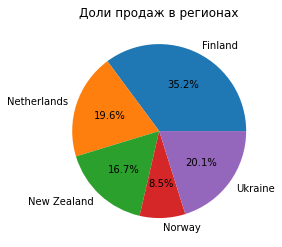

In [14]:
plt.title('Доли продаж в регионах')
plt.pie(sales_sum_by_region[:, 1].astype(float), labels=sales_sum_by_region[:, 0], autopct='%1.1f%%')
plt.show()

### Топ 5 продуктов по продажам и построить круговую гистограмму, где будет 6 секторов: топ 5 и все остальное

In [15]:
sort_indexes = np.argsort(-sales_sum_by_id[:, 1].astype(float))

In [16]:
sales_sum_by_id_sorted = sales_sum_by_id[(sort_indexes)]

In [17]:
sales_sum_by_id_sorted

array([['16', '982.24'],
       ['3', '897.8999999999999'],
       ['2', '715.8100000000001'],
       ['1', '706.34'],
       ['4', '588.27'],
       ['14', '530.04'],
       ['18', '525.38'],
       ['7', '494.21'],
       ['9', '439.83000000000004'],
       ['6', '406.36'],
       ['17', '391.82'],
       ['8', '381.63'],
       ['19', '373.78'],
       ['10', '272.7'],
       ['13', '241.14'],
       ['5', '191.01'],
       ['15', '163.66000000000003'],
       ['12', '135.9'],
       ['11', '124.32']], dtype='<U32')

In [18]:
other_sales_sum = np.sum(sales_sum_by_id_sorted[5:, 1].astype(float))

In [19]:
data_for_chart = np.concatenate([sales_sum_by_id_sorted[:5], np.array([['others', other_sales_sum]])])

In [20]:
data_for_chart

array([['16', '982.24'],
       ['3', '897.8999999999999'],
       ['2', '715.8100000000001'],
       ['1', '706.34'],
       ['4', '588.27'],
       ['others', '4671.779999999999']], dtype='<U32')

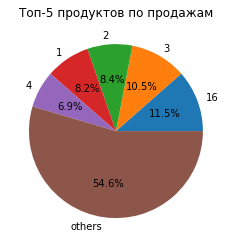

In [21]:
plt.title('Топ-5 продуктов по продажам')
plt.pie(data_for_chart[:, 1].astype(float), labels=data_for_chart[:, 0], autopct='%1.1f%%')
plt.show()

## Добавить колонки с названием валюты и величиной продаж в рублях

In [22]:
def get_eu_countries():
    main_page = "https://european-union.europa.eu/principles-countries-history/country-profiles_en"
    page_num = 0
    countries = []

    while True:
        url = main_page + f'?page={page_num}'
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        country_elements = soup.find_all("h1", class_="ecl-content-block__title")
        countries.extend([element.get_text(strip=True) for element in country_elements])
        next_button = soup.find('li', class_='ecl-pagination__item--next')

        if next_button: 
            page_num += 1
        else:
            break
    return countries

In [23]:
def get_country_currencies(): 
    currencies = {}
    url = "https://www.exchangerate-api.com/docs/supported-currencies"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    tables = soup.find_all("table")
    if tables: 
        tables = tables[1:]
        for table in tables:
            for row in table.find_all("tr")[1:]:
                columns = row.find_all("td")
                currency_code = columns[0].text.strip()
                country = columns[2].text.strip()
                currencies[country] = currency_code

    eu_countries = get_eu_countries()
    for country in eu_countries:
        currencies[country] = 'EUR'
    return currencies

In [24]:
def merge_data(dict1, array2, merge_array_index_col): 
    merged_data = []
    
    for row in array2:
        merge_value = row[merge_array_index_col]
        value = dict1.get(merge_value, 'N/A')
        merged_row = [*row, value]
        merged_data.append(merged_row)
    
    return merged_data

In [25]:
def get_rub_rates():
    response = requests.get("https://open.er-api.com/v6/latest/RUB")
    rates = response.json()["rates"]
    rates_dict = {}
    for currency, rate in rates.items():
        rates_dict[currency] = rate

    return rates_dict

In [26]:
currency_codes_by_country = get_country_currencies()
currency_codes_by_country

{'Libya': 'LYD',
 'South Sudan': 'SSP',
 'Syria': 'SYP',
 'Venezuela': 'VES',
 'Yemen': 'YER',
 'Zimbabwe': 'ZWL',
 'United Arab Emirates': 'AED',
 'Afghanistan': 'AFN',
 'Albania': 'ALL',
 'Armenia': 'AMD',
 'Netherlands Antilles': 'ANG',
 'Angola': 'AOA',
 'Argentina': 'ARS',
 'Australia': 'AUD',
 'Aruba': 'AWG',
 'Azerbaijan': 'AZN',
 'Bosnia and Herzegovina': 'BAM',
 'Barbados': 'BBD',
 'Bangladesh': 'BDT',
 'Bulgaria': 'EUR',
 'Bahrain': 'BHD',
 'Burundi': 'BIF',
 'Bermuda': 'BMD',
 'Brunei': 'BND',
 'Bolivia': 'BOB',
 'Brazil': 'BRL',
 'Bahamas': 'BSD',
 'Bhutan': 'BTN',
 'Botswana': 'BWP',
 'Belarus': 'BYN',
 'Belize': 'BZD',
 'Canada': 'CAD',
 'Democratic Republic of the Congo': 'CDF',
 'Switzerland': 'CHF',
 'Chile': 'CLP',
 'China': 'CNY',
 'Colombia': 'COP',
 'Costa Rica': 'CRC',
 'Cuba': 'CUP',
 'Cape Verde': 'CVE',
 'Czech Republic': 'CZK',
 'Djibouti': 'DJF',
 'Denmark': 'EUR',
 'Dominican Republic': 'DOP',
 'Algeria': 'DZD',
 'Egypt': 'EGP',
 'Eritrea': 'ERN',
 'Ethiopia

In [27]:
rates_dict = get_rub_rates()
rates_dict

{'RUB': 1,
 'AED': 0.04579,
 'AFN': 1.093712,
 'ALL': 1.28399,
 'AMD': 4.81915,
 'ANG': 0.022318,
 'AOA': 6.809894,
 'ARS': 2.932659,
 'AUD': 0.019009,
 'AWG': 0.022318,
 'AZN': 0.02124,
 'BAM': 0.022644,
 'BBD': 0.024937,
 'BDT': 1.345558,
 'BGN': 0.022644,
 'BHD': 0.004688,
 'BIF': 35.195425,
 'BMD': 0.012468,
 'BND': 0.016809,
 'BOB': 0.086436,
 'BRL': 0.061967,
 'BSD': 0.012468,
 'BTN': 1.030195,
 'BWP': 0.169868,
 'BYN': 0.036441,
 'BZD': 0.024937,
 'CAD': 0.01691,
 'CDF': 29.030065,
 'CHF': 0.011269,
 'CLP': 10.006228,
 'CNY': 0.087946,
 'COP': 55.757734,
 'CRC': 6.715373,
 'CUP': 0.29924,
 'CVE': 1.276603,
 'CZK': 0.274609,
 'DJF': 2.215884,
 'DKK': 0.086373,
 'DOP': 0.681994,
 'DZD': 1.705584,
 'EGP': 0.385779,
 'ERN': 0.187025,
 'ETB': 0.681437,
 'EUR': 0.011578,
 'FJD': 0.027945,
 'FKP': 0.010067,
 'FOK': 0.086373,
 'GBP': 0.010067,
 'GEL': 0.032297,
 'GGP': 0.010067,
 'GHS': 0.139972,
 'GIP': 0.010067,
 'GMD': 0.738539,
 'GNF': 107.052838,
 'GTQ': 0.097466,
 'GYD': 2.640203,

In [28]:
data_with_currency_codes = merge_data(currency_codes_by_country, data, 2)

In [29]:
merged_data = np.array(merge_data(rates_dict, data_with_currency_codes, 3))

In [30]:
merged_data[:, 4] = merged_data[:, 1].astype(float) / merged_data[:, 4].astype(float)
merged_data[:, 4] = np.round(merged_data[:, 4].astype(float), 4)

In [31]:
merged_data

array([['8', '184.63', 'Finland', 'EUR', '15946.6229'],
       ['15', '51.86', 'Ukraine', 'UAH', '112.5202'],
       ['6', '305.31', 'Finland', 'EUR', '26369.8394'],
       ['19', '347.38', 'Finland', 'EUR', '30003.4548'],
       ['7', '327.95', 'Netherlands', 'EUR', '28325.2721'],
       ['16', '293.16', 'Ukraine', 'UAH', '636.0668'],
       ['7', '166.26', 'New Zealand', 'NZD', '8164.4078'],
       ['4', '265.2', 'Ukraine', 'UAH', '575.4022'],
       ['13', '180.38', 'Norway', 'NOK', '1319.0879'],
       ['17', '125.06', 'Finland', 'EUR', '10801.5201'],
       ['8', '149.94', 'Finland', 'EUR', '12950.4232'],
       ['14', '57.05', 'Norway', 'NOK', '417.1968'],
       ['4', '94.81', 'Ukraine', 'UAH', '205.7085'],
       ['16', '170.04', 'New Zealand', 'NZD', '8350.0295'],
       ['16', '253.17', 'Finland', 'EUR', '21866.4709'],
       ['9', '211.4', 'Ukraine', 'UAH', '458.6728'],
       ['3', '67.44', 'Ukraine', 'UAH', '146.324'],
       ['15', '17.87', 'Ukraine', 'UAH', '38.7724'],
 

In [32]:
np.savetxt("regions_results.txt", merged_data, delimiter=",", header="id,sales,country,currency_code,sales_rub", fmt='%s')